## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries

import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import codecs

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(nltk_data[:30])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Splitting into train and test

random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.3)


# length of training and test sets

print(len(train_set))
print(len(test_set))
print(train_set[:30])

2739
1175
[[('The', 'DET'), ('recent', 'ADJ'), ('cash', 'NOUN'), ('squeeze', 'NOUN'), ('at', 'ADP'), ('Campeau', 'NOUN'), ('Corp.', 'NOUN'), (',', '.'), ('First', 'NOUN'), ('Boston', 'NOUN'), ("'s", 'PRT'), ('most', 'ADJ'), ('lucrative', 'ADJ'), ('client', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('decade', 'NOUN'), (',', '.'), ('is', 'VERB'), ('proving', 'VERB'), ('costly', 'ADJ'), ('to', 'PRT'), ('First', 'NOUN'), ('Boston', 'NOUN'), ('because', 'ADP'), ('it', 'PRON'), ('arranged', 'VERB'), ('more', 'ADJ'), ('than', 'ADP'), ('$', '.'), ('3', 'NUM'), ('billion', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('high-yield', 'ADJ'), (',', '.'), ('high-risk', 'ADJ'), ('junk', 'NOUN'), ('financings', 'NOUN'), ('for', 'ADP'), ('Campeau', 'NOUN'), ('units', 'NOUN'), ('.', '.')], [('She', 'PRON'), ('said', 'VERB'), ('0', 'X'), ('there', 'DET'), ('is', 'VERB'), ('``', '.'), ('growing', 'VERB'), ('realization', 'NOUN'), ('*ICH*-1', 'X'), ("''", '.'), ('around', 'ADP'), ('the', 'DET'), ('world', 'NOUN'), 

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

70176

In [6]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['The',
 'recent',
 'cash',
 'squeeze',
 'at',
 'Campeau',
 'Corp.',
 ',',
 'First',
 'Boston']

In [7]:
# vocabulary
V = set(tokens)
print(len(V))

10316


In [8]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)

12
{'X', 'PRON', '.', 'ADP', 'VERB', 'NUM', 'PRT', 'NOUN', 'DET', 'ADV', 'CONJ', 'ADJ'}


### Build the vanilla Viterbi based POS tagger

In [9]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [10]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [11]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [12]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [13]:
tags_matrix

array([[7.65892789e-02, 5.05532660e-02, 1.68583199e-01, 1.45150796e-01,
        2.08505094e-01, 1.30180083e-03, 1.84638754e-01, 6.16185740e-02,
        5.40247336e-02, 2.32154485e-02, 9.98047274e-03, 1.58385765e-02],
       [9.42887962e-02, 7.54310330e-03, 3.93318981e-02, 2.15517245e-02,
        4.82219815e-01, 9.15948302e-03, 1.13146547e-02, 2.07974136e-01,
        1.02370689e-02, 3.44827585e-02, 5.92672406e-03, 7.59698302e-02],
       [2.60890666e-02, 6.46766201e-02, 9.33139175e-02, 9.35566053e-02,
        8.61545950e-02, 8.14221576e-02, 2.66957888e-03, 2.25700766e-01,
        1.73401281e-01, 5.29062003e-02, 5.59398122e-02, 4.40480523e-02],
       [3.54187824e-02, 6.63376376e-02, 3.99187095e-02, 1.69835966e-02,
        9.14501399e-03, 5.84990568e-02, 1.45158952e-03, 3.27043116e-01,
        3.26462477e-01, 1.36449412e-02, 7.25794758e-04, 1.04369283e-01],
       [2.15467855e-01, 3.44791003e-02, 3.72374281e-02, 9.03882906e-02,
        1.70804158e-01, 2.22788025e-02, 3.16146836e-02, 1.10

In [14]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,X,PRON,.,ADP,VERB,NUM,PRT,NOUN,DET,ADV,CONJ,ADJ
X,0.076589,0.050553,0.168583,0.145151,0.208505,0.001302,0.184639,0.061619,0.054025,0.023215,0.009980,0.015839
PRON,0.094289,0.007543,0.039332,0.021552,0.482220,0.009159,0.011315,0.207974,0.010237,0.034483,0.005927,0.075970
.,0.026089,0.064677,0.093314,0.093557,0.086155,0.081422,0.002670,0.225701,0.173401,0.052906,0.055940,0.044048
ADP,0.035419,0.066338,0.039919,0.016984,0.009145,0.058499,0.001452,0.327043,0.326462,0.013645,0.000726,0.104369
VERB,0.215468,0.034479,0.037237,0.090388,0.170804,0.022279,0.031615,0.110333,0.131657,0.083811,0.005729,0.066200
NUM,0.215138,0.001645,0.115590,0.035788,0.019745,0.187988,0.028795,0.344303,0.002879,0.003702,0.011107,0.033320
PRT,0.012411,0.018617,0.042553,0.017730,0.400266,0.054965,0.001773,0.246897,0.106383,0.011082,0.002216,0.085106
NOUN,0.029212,0.004720,0.241393,0.177306,0.146058,0.008942,0.044314,0.261960,0.013612,0.016990,0.043221,0.012271
DET,0.047916,0.003774,0.018215,0.009518,0.038891,0.022973,0.000328,0.634559,0.006400,0.010666,0.000328,0.206433
ADV,0.026268,0.016304,0.136322,0.114130,0.347826,0.033967,0.015399,0.027174,0.066576,0.076540,0.005435,0.134058


In [15]:
tags_df.loc['.', :]

X       0.026089
PRON    0.064677
.       0.093314
ADP     0.093557
VERB    0.086155
NUM     0.081422
PRT     0.002670
NOUN    0.225701
DET     0.173401
ADV     0.052906
CONJ    0.055940
ADJ     0.044048
Name: ., dtype: float32

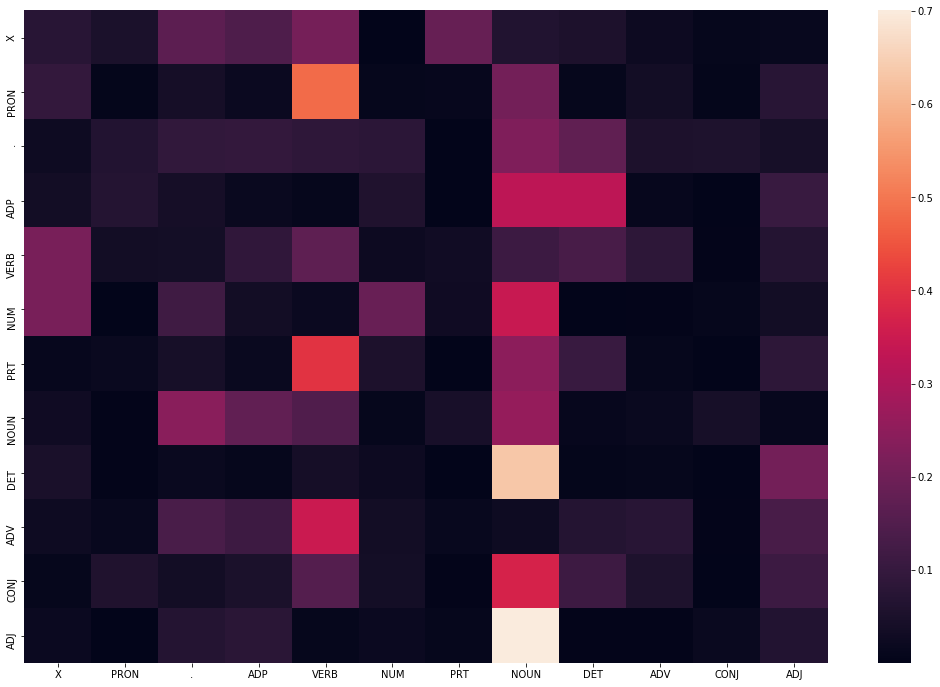

In [16]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


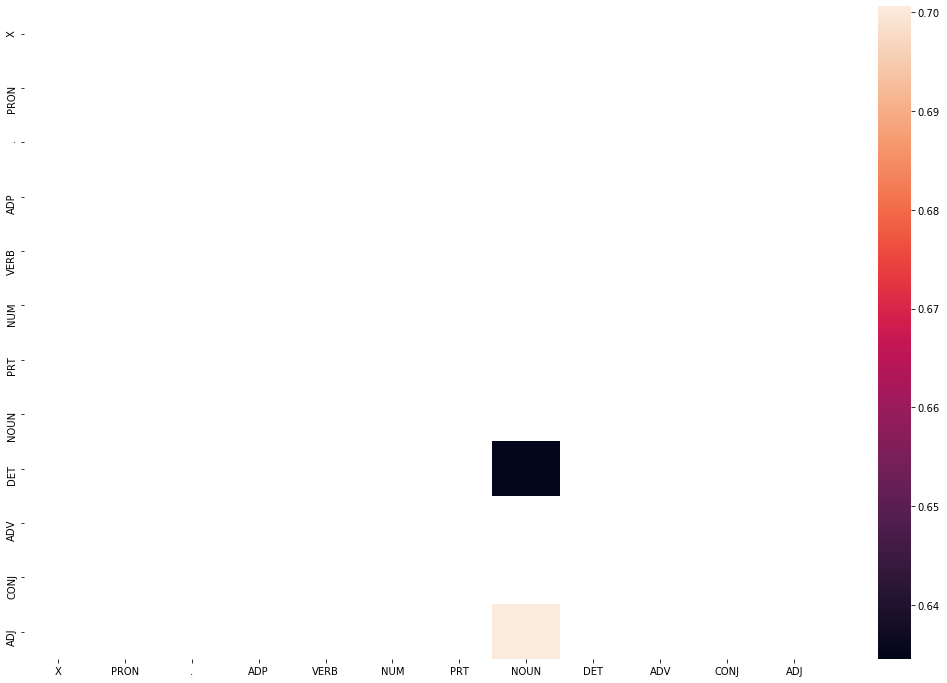

In [17]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [18]:
## Viterbi Algorithm

len(train_tagged_words)

70176

In [19]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [20]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('``', '.'),
  ('Florio', 'NOUN'),
  ("'s", 'VERB'),
  ('lying', 'VERB'),
  (',', '.'),
  ("''", '.'),
  ('the', 'DET'),
  ('voice', 'NOUN'),
  ('goes', 'VERB'),
  ('on', 'PRT'),
  (',', '.'),
  ('because', 'ADP'),
  ('``', '.'),
  ('the', 'DET'),
  ('barrel', 'NOUN'),
  ('on', 'ADP'),
  ('Courter', 'NOUN'),
  ("'s", 'PRT'),
  ('land', 'NOUN'),
  ('...', '.'),
  ('contained', 'VERB'),
  ('heating', 'NOUN'),
  ('oil', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('cleaned', 'VERB'),
  ('*-1', 'X'),
  ('up', 'PRT'),
  ('and', 'CONJ'),
  ('caused', 'VERB'),
  ('no', 'DET'),
  ('pollution', 'NOUN'),
  ('.', '.'),
  ("''", '.')],
 [('Charles', 'NOUN'),
  ('D.', 'NOUN'),
  ('Phipps', 'NOUN'),
  ('Sr.', 'NOUN'),
  (',', '.'),
  ('Hermitage', 'NOUN'),
  (',', '.'),
  ('Pa.', 'NOUN'),
  (',', '.'),
  ('fined', 'VERB'),
  ('*-1', 'X'),
  ('$', '.'),
  ('10,000', 'NUM'),
  ('*U*', 'X'),
  (';', '.'),
  ('David', 'NOUN'),
  ('Scott', 'NOUN'),
  ('Rankin', 'NOUN'),
  (',', '.'),
  ('Lake', 'NOUN')

In [21]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [22]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  42.53673505783081
[('``', '.'), ('Florio', 'NOUN'), ("'s", 'PRT'), ('lying', 'VERB'), (',', '.'), ("''", '.'), ('the', 'DET'), ('voice', 'NOUN'), ('goes', 'VERB'), ('on', 'ADP'), (',', '.'), ('because', 'ADP'), ('``', '.'), ('the', 'DET'), ('barrel', 'NOUN'), ('on', 'ADP'), ('Courter', 'NOUN'), ("'s", 'PRT'), ('land', 'VERB'), ('...', '.'), ('contained', 'VERB'), ('heating', 'VERB'), ('oil', 'NOUN'), (',', '.'), ('was', 'VERB'), ('cleaned', 'X'), ('*-1', 'X'), ('up', 'PRT'), ('and', 'CONJ'), ('caused', 'VERB'), ('no', 'DET'), ('pollution', 'X'), ('.', '.'), ("''", '.'), ('Charles', 'NOUN'), ('D.', 'NOUN'), ('Phipps', 'X'), ('Sr.', 'X'), (',', '.'), ('Hermitage', 'NOUN'), (',', '.'), ('Pa.', 'NOUN'), (',', '.'), ('fined', 'VERB'), ('*-1', 'X'), ('$', '.'), ('10,000', 'NUM'), ('*U*', 'X'), (';', '.'), ('David', 'NOUN'), ('Scott', 'NOUN'), ('Rankin', 'X'), (',', '.'), ('Lake', 'NOUN'), ('St.', 'NOUN'), ('Louis', 'NOUN'), (',', '.'), ('Mo.', 'X'), (',', '.'), ('$', 

In [23]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = round(len(check)/len(tagged_seq),2)
accuracy

0.89

#### We get around 90% of accuracy with the default Viterbi algorithm.
#### Let's compare with the test sentences and see how it tagged the sentences

In [24]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('Florio', 'NOUN'), (("'s", 'PRT'), ("'s", 'VERB'))],
 [('goes', 'VERB'), (('on', 'ADP'), ('on', 'PRT'))],
 [("'s", 'PRT'), (('land', 'VERB'), ('land', 'NOUN'))],
 [('contained', 'VERB'), (('heating', 'VERB'), ('heating', 'NOUN'))],
 [('was', 'VERB'), (('cleaned', 'X'), ('cleaned', 'VERB'))],
 [('no', 'DET'), (('pollution', 'X'), ('pollution', 'NOUN'))],
 [('D.', 'NOUN'), (('Phipps', 'X'), ('Phipps', 'NOUN'))],
 [('Phipps', 'NOUN'), (('Sr.', 'X'), ('Sr.', 'NOUN'))],
 [('Scott', 'NOUN'), (('Rankin', 'X'), ('Rankin', 'NOUN'))],
 [(',', '.'), (('Mo.', 'X'), ('Mo.', 'NOUN'))],
 [(';', '.'), (('Leigh', 'X'), ('Leigh', 'NOUN'))],
 [('A.', 'NOUN'), (('Sanderoff', 'X'), ('Sanderoff', 'NOUN'))],
 [(',', '.'), (('Gaithersburg', 'X'), ('Gaithersburg', 'NOUN'))],
 [(',', '.'), (('Md.', 'X'), ('Md.', 'NOUN'))],
 [('$', '.'), (('12,252', 'X'), ('12,252', 'NUM'))],
 [(';', '.'), (('Sandra', 'X'), ('Sandra', 'NOUN'))],
 [(',', '.'), (('Ridgefield', 'X'), ('Ridgefield', 'NOUN'))],
 [('G.', 'NOUN'), (

In [25]:
print(tagged_seq)
print(difference)

[('``', '.'), ('Florio', 'NOUN'), ("'s", 'PRT'), ('lying', 'VERB'), (',', '.'), ("''", '.'), ('the', 'DET'), ('voice', 'NOUN'), ('goes', 'VERB'), ('on', 'ADP'), (',', '.'), ('because', 'ADP'), ('``', '.'), ('the', 'DET'), ('barrel', 'NOUN'), ('on', 'ADP'), ('Courter', 'NOUN'), ("'s", 'PRT'), ('land', 'VERB'), ('...', '.'), ('contained', 'VERB'), ('heating', 'VERB'), ('oil', 'NOUN'), (',', '.'), ('was', 'VERB'), ('cleaned', 'X'), ('*-1', 'X'), ('up', 'PRT'), ('and', 'CONJ'), ('caused', 'VERB'), ('no', 'DET'), ('pollution', 'X'), ('.', '.'), ("''", '.'), ('Charles', 'NOUN'), ('D.', 'NOUN'), ('Phipps', 'X'), ('Sr.', 'X'), (',', '.'), ('Hermitage', 'NOUN'), (',', '.'), ('Pa.', 'NOUN'), (',', '.'), ('fined', 'VERB'), ('*-1', 'X'), ('$', '.'), ('10,000', 'NUM'), ('*U*', 'X'), (';', '.'), ('David', 'NOUN'), ('Scott', 'NOUN'), ('Rankin', 'X'), (',', '.'), ('Lake', 'NOUN'), ('St.', 'NOUN'), ('Louis', 'NOUN'), (',', '.'), ('Mo.', 'X'), (',', '.'), ('$', '.'), ('15,000', 'NUM'), ('*U*', 'X'), (';

### Solve the problem of unknown words

In [26]:
#Read the text file
Sample_text=[]
U = codecs.open("Sample text.txt", encoding='utf-8')
for text in U:
    print(text)
    Sample_text.append(text)

Android is a mobile operating system developed by Google.

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Twitter is an online news and social networking service on which users post and interact with messages known as tweets.

Before entering politics, Donald Trump was a domineering businessman and a television personality.

The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.

Show me the cheapest round trips from Dallas to Atlanta

I would like to see flights from Denver to Philadelphia.

Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.

NASA invited social media users to experience the launch of ICESAT-2 Satelli

In [27]:
Sample_text

['Android is a mobile operating system developed by Google.\r\n',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\r\n',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\r\n",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\r\n',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\r\n',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\r\n',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\r\n',
 'Show me the cheapest round trips from Dallas to Atlanta\r\n',
 'I would like to see flights from Denver to Philadelphia.\r\n',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\r\n',
 'NASA

In [28]:

#Strip the special characters and empty strings in the list file
stripped_lines =[sent.rstrip() for sent in Sample_text if sent.rstrip()!='']
stripped_lines

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [29]:

#Get the words in the test set which are incorrectly classified
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('Florio', 'NOUN'), (("'s", 'PRT'), ("'s", 'VERB'))],
 [('goes', 'VERB'), (('on', 'ADP'), ('on', 'PRT'))],
 [("'s", 'PRT'), (('land', 'VERB'), ('land', 'NOUN'))],
 [('contained', 'VERB'), (('heating', 'VERB'), ('heating', 'NOUN'))],
 [('was', 'VERB'), (('cleaned', 'X'), ('cleaned', 'VERB'))],
 [('no', 'DET'), (('pollution', 'X'), ('pollution', 'NOUN'))],
 [('D.', 'NOUN'), (('Phipps', 'X'), ('Phipps', 'NOUN'))],
 [('Phipps', 'NOUN'), (('Sr.', 'X'), ('Sr.', 'NOUN'))],
 [('Scott', 'NOUN'), (('Rankin', 'X'), ('Rankin', 'NOUN'))],
 [(',', '.'), (('Mo.', 'X'), ('Mo.', 'NOUN'))],
 [(';', '.'), (('Leigh', 'X'), ('Leigh', 'NOUN'))],
 [('A.', 'NOUN'), (('Sanderoff', 'X'), ('Sanderoff', 'NOUN'))],
 [(',', '.'), (('Gaithersburg', 'X'), ('Gaithersburg', 'NOUN'))],
 [(',', '.'), (('Md.', 'X'), ('Md.', 'NOUN'))],
 [('$', '.'), (('12,252', 'X'), ('12,252', 'NUM'))],
 [(';', '.'), (('Sandra', 'X'), ('Sandra', 'NOUN'))],
 [(',', '.'), (('Ridgefield', 'X'), ('Ridgefield', 'NOUN'))],
 [('G.', 'NOUN'), (

In [30]:

#Get the words in the test set which are incorrectly classified
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('Florio', 'NOUN'), (("'s", 'PRT'), ("'s", 'VERB'))],
 [('goes', 'VERB'), (('on', 'ADP'), ('on', 'PRT'))],
 [("'s", 'PRT'), (('land', 'VERB'), ('land', 'NOUN'))],
 [('contained', 'VERB'), (('heating', 'VERB'), ('heating', 'NOUN'))],
 [('was', 'VERB'), (('cleaned', 'X'), ('cleaned', 'VERB'))],
 [('no', 'DET'), (('pollution', 'X'), ('pollution', 'NOUN'))],
 [('D.', 'NOUN'), (('Phipps', 'X'), ('Phipps', 'NOUN'))],
 [('Phipps', 'NOUN'), (('Sr.', 'X'), ('Sr.', 'NOUN'))],
 [('Scott', 'NOUN'), (('Rankin', 'X'), ('Rankin', 'NOUN'))],
 [(',', '.'), (('Mo.', 'X'), ('Mo.', 'NOUN'))],
 [(';', '.'), (('Leigh', 'X'), ('Leigh', 'NOUN'))],
 [('A.', 'NOUN'), (('Sanderoff', 'X'), ('Sanderoff', 'NOUN'))],
 [(',', '.'), (('Gaithersburg', 'X'), ('Gaithersburg', 'NOUN'))],
 [(',', '.'), (('Md.', 'X'), ('Md.', 'NOUN'))],
 [('$', '.'), (('12,252', 'X'), ('12,252', 'NUM'))],
 [(';', '.'), (('Sandra', 'X'), ('Sandra', 'NOUN'))],
 [(',', '.'), (('Ridgefield', 'X'), ('Ridgefield', 'NOUN'))],
 [('G.', 'NOUN'), (

In [31]:
#Get the predictions on the test sentences
sample_pred_list =[]
for line in stripped_lines:
    sample_pred_list=sample_pred_list+list(Viterbi(word_tokenize(line)))
sample_pred_list

[('Android', 'X'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'X'),
 ('.', '.'),
 ('Android', 'X'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'X'),
 ('worldwide', 'X'),
 ('on', 'ADP'),
 ('smartphones', 'X'),
 ('since', 'ADP'),
 ('2011', 'X'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'X'),
 ('.', '.'),
 ('Google', 'X'),
 ('and', 'CONJ'),
 ('Twitter', 'X'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'X'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'X'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'X'),
 ("'s", 'PRT'),
 ('firehose', 'X'),
 ('.', '.'),
 ('Twitter', 'X'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'X'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'X'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'DE

In [32]:
#Get the tokens in the test file
sample_words=[tokens for line in stripped_lines for tokens in word_tokenize(line)]

In [33]:
#Get the list of words which are present in test lines but not in the training corpus
words_not_in_corpus = list(set(sample_words) - set(tokens))
words_not_in_corpus

['21st',
 'trips',
 'NASA',
 'messages',
 'contested',
 'FIFA',
 'Android',
 'OS',
 'arriving',
 'domineering',
 'Satellite',
 'smartphones',
 'personality',
 'worldwide',
 'interact',
 'Twitter',
 'Denver',
 'Cup',
 'tournament',
 'firehose',
 '2013',
 'invited',
 'ICESAT-2',
 '2015',
 'networking',
 'online',
 'Google',
 'tweets',
 '2018',
 '2011']

In [34]:
#Get the tags predicted for unknown words
[tup for tup in sample_pred_list for word in words_not_in_corpus if tup[0]==word ]

[('Android', 'X'),
 ('Google', 'X'),
 ('Android', 'X'),
 ('OS', 'X'),
 ('worldwide', 'X'),
 ('smartphones', 'X'),
 ('2011', 'X'),
 ('2013', 'X'),
 ('Google', 'X'),
 ('Twitter', 'X'),
 ('2015', 'X'),
 ('Google', 'X'),
 ('Twitter', 'X'),
 ('firehose', 'X'),
 ('Twitter', 'X'),
 ('online', 'X'),
 ('networking', 'X'),
 ('interact', 'X'),
 ('messages', 'X'),
 ('tweets', 'X'),
 ('domineering', 'X'),
 ('personality', 'X'),
 ('2018', 'X'),
 ('FIFA', 'X'),
 ('Cup', 'X'),
 ('21st', 'X'),
 ('FIFA', 'X'),
 ('Cup', 'X'),
 ('tournament', 'X'),
 ('contested', 'X'),
 ('Cup', 'X'),
 ('trips', 'X'),
 ('Denver', 'X'),
 ('arriving', 'X'),
 ('NASA', 'X'),
 ('invited', 'X'),
 ('ICESAT-2', 'X'),
 ('Satellite', 'X')]

In [35]:
#Let us see the count of all tags in the training set
from collections import Counter
tag_counts = Counter(pair[1] for pair in train_tagged_words)
tag_counts

Counter({'DET': 6094,
         'ADJ': 4462,
         'NOUN': 20129,
         'ADP': 6889,
         '.': 8241,
         'PRT': 2256,
         'VERB': 9426,
         'PRON': 1856,
         'NUM': 2431,
         'X': 4609,
         'CONJ': 1575,
         'ADV': 2208})

In [36]:
# see most common tags can in the training corpus
tag_counts.most_common(5)

[('NOUN', 20129), ('VERB', 9426), ('.', 8241), ('ADP', 6889), ('DET', 6094)]

In [37]:

#Lets see count of incorrectly classfied words for each tag
wrong_tag_counts = Counter(pair[1][0][1] for pair in incorrect_tagged_cases)
wrong_tag_counts

Counter({'PRT': 1, 'ADP': 1, 'VERB': 2, 'X': 23})

In [38]:

# Let us see the percentage of verbs which are classifed as 'verb which end with 'ed'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ed_verbs = [pair for pair in verbs if pair[0].endswith('ed')]
print(len(ed_verbs) / len(verbs))
ed_verbs[:20]

0.20485890091237005


[('arranged', 'VERB'),
 ('worried', 'VERB'),
 ('based', 'VERB'),
 ('compared', 'VERB'),
 ('agreed', 'VERB'),
 ('acquired', 'VERB'),
 ('cited', 'VERB'),
 ('used', 'VERB'),
 ('expected', 'VERB'),
 ('delivered', 'VERB'),
 ('produced', 'VERB'),
 ('reorganized', 'VERB'),
 ('named', 'VERB'),
 ('noted', 'VERB'),
 ('expected', 'VERB'),
 ('attributed', 'VERB'),
 ('ended', 'VERB'),
 ('urged', 'VERB'),
 ('auctioned', 'VERB'),
 ('expressed', 'VERB')]

In [39]:
# Let us see the percentage of verbs which are classifed as 'verb which end with 'ing'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ing_verbs = [pair for pair in verbs if pair[0].endswith('ing')]
print(len(ing_verbs) / len(verbs))
ing_verbs[:20]

0.109484404837683


[('proving', 'VERB'),
 ('growing', 'VERB'),
 ('trading', 'VERB'),
 ('offending', 'VERB'),
 ('continuing', 'VERB'),
 ('banning', 'VERB'),
 ('equaling', 'VERB'),
 ('reflecting', 'VERB'),
 ('according', 'VERB'),
 ('according', 'VERB'),
 ('acknowledging', 'VERB'),
 ('going', 'VERB'),
 ('increasing', 'VERB'),
 ('maintaining', 'VERB'),
 ('increasing', 'VERB'),
 ('yielding', 'VERB'),
 ('according', 'VERB'),
 ('producing', 'VERB'),
 ('providing', 'VERB'),
 ('noticing', 'VERB')]

In [40]:
#Lets see percentage of Adjective tags followed by nouns
# create a list of all tags (without the words)
tags = [pair[1] for pair in train_tagged_words]

# create a list of Adj tags
adj_tags = [t for t in tags if t == 'ADJ']

# create a list of (ADJ, Noun) tags
adj_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADJ' and tags[index+1]=='NOUN']

print(len(adj_tags))
print(len(adj_noun_tags))
print(len(adj_noun_tags) / len(adj_tags))

4462
3126
0.7005826983415508


In [41]:
#Lets see percentage of Determinent tags followed by nouns
dt_tags = [t for t in tags if t == 'DET']
dt_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='DET' and tags[index+1]=='NOUN']

print(len(dt_tags))
print(len(dt_noun_tags))
print(len(dt_noun_tags) / len(dt_tags))

6094
3867
0.6345585822120118


In [42]:
#Lets see percentage of Adverbs tags followed by Verbs
adv_tags = [t for t in tags if t == 'ADV']
adv_vb_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADV' and tags[index+1]=='VERB']

print(len(adv_tags))
print(len(adv_vb_tags))
print(len(adv_vb_tags) / len(adv_tags))

2208
768
0.34782608695652173


In [43]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense verbs
    (r'.*es$', 'VERB'),               # singular present verbs
    (r'.*ould$', 'VERB'),              # modal verbs
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),                # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'.*', 'NOUN')                    # nouns
]

In [44]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

lexicon_tagger.evaluate(test_set)

0.9475081967213115

#### Evaluating tagging accuracy

In [45]:
#Trigram tagger backed by Bigram backed by Unigram which is backed by rule based tagger
t0 = nltk.RegexpTagger(patterns)
t1 = nltk.UnigramTagger(train_set, backoff=t0)
t2 = nltk.BigramTagger(train_set, backoff=t1)
t3 = nltk.TrigramTagger(train_set, backoff=t2)

In [46]:

#Import libraries for brill
import nltk.tag
from nltk.tag import brill
from nltk.tag.brill import *
from nltk.tbl.template import Template
from nltk.tag import BrillTaggerTrainer

#Clear existing templates if any
Template._cleartemplates()

#Load the fntbl37 template
templates = fntbl37()
 
#Train the Brill model
trainer = BrillTaggerTrainer(t3, templates)
brill_tagger = trainer.train(train_set, max_rules=100, min_score=3)

In [47]:
# Viterbi Heuristic
def Viterbi_updated_model_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is zero
        if(pmax==0.0):
            #If state probability is zero i.e if the word is unknown if updates the tag based on the brill tagger
            state_max = brill_tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [48]:
# tagging the test sentences with the updated Viterbi algorithm
start = time.time()
updated_tagged_seq = Viterbi_updated_model_1(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

47.83265662193298


In [49]:
# Calculate the accuracy for the updated Viterbi algorithm - Model 1
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(updated_tagged_seq)
accuracy

0.975

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [50]:
#Let us print the test lines with the initial Viterbi algorithm
for line in stripped_lines:
    print(list(Viterbi(word_tokenize(line))))

[('Android', 'X'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'X'), ('.', '.')]
[('Android', 'X'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'X'), ('worldwide', 'X'), ('on', 'ADP'), ('smartphones', 'X'), ('since', 'ADP'), ('2011', 'X'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'X'), ('.', '.')]
[('Google', 'X'), ('and', 'CONJ'), ('Twitter', 'X'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'X'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'X'), ("'s", 'PRT'), ('firehose', 'X'), ('.', '.')]
[('Twitter', 'X'), ('is', 'VERB'), ('an', 'DET'), ('online', 'X'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'X'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', '

In [51]:

#Let us print the test lines with the updated Viterbi algorithm
for line in stripped_lines:
    print(list(Viterbi_updated_model_1(word_tokenize(line))))

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]
[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'VERB'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET')

In [52]:
# Viterbi Heuristic
def Viterbi_updated_model_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is zero
        if(pmax<0.001):
            #If state probability is zero i.e if the word is unknown if updates the tag based on the brill tagger
            state_max = brill_tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [53]:
# tagging the test sentences with the updated Viterbi algorithm 
start = time.time()
updated_tagged_seq = Viterbi_updated_model_2(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

43.97004818916321


In [54]:

# Calculate the accuracy for the updated Viterbi algorithm - Model 2
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(updated_tagged_seq)
accuracy

0.975